In [1]:
import os
import pandas as pd
import numpy as np
import torch
import glob
%matplotlib inline
import matplotlib.pyplot as plt

# Read accuracy results

In [2]:
def get_results(glob_expr):
    """Get accuracies from weight files"""
    accuracies = []
    for filename in glob.glob(glob_expr):
        sd = torch.load(filename)
        accuracies.append(sd['acc'] * 100)
    return accuracies

logs_dir = 'logs'
results = {
    'resnet18_trapezoids': get_results(os.path.join(logs_dir, 'wheat_square_vs_trapezoid_000', '*trapezoids_cross*', 'checkpoints', 'best.pt')),
    'resnet18_trapezoids_224x224': get_results(os.path.join(logs_dir, 'wheat_square_vs_trapezoid_000', '*trapezoids_224x224*', 'checkpoints', 'best.pt')),
    'resnet18_squares': get_results(os.path.join(logs_dir, 'wheat_square_vs_trapezoid_000', '*squares_*', 'checkpoints', 'best.pt')),
    'resnet18_squares_rewarped': get_results(os.path.join(logs_dir, 'wheat_square_vs_trapezoid_000', '*squares2*', 'checkpoints', 'best.pt')),
    'mobilenetv2_squares': get_results(os.path.join(logs_dir, 'other_archs', '*mobilenetv2*', 'checkpoints', 'best.pt')),
    'squeezenetv11_squares': get_results(os.path.join(logs_dir, 'other_archs', '*squeezenet11*', 'checkpoints', 'best.pt')),
    'efficientnetb0_squares': get_results(os.path.join(logs_dir, 'other_archs', '*efficientnetb0*', 'checkpoints', 'best.pt')),
    'mobilenetv2_192x192': get_results(os.path.join(logs_dir, 'input_resolution', '*mobilenetv2_192x192*', 'checkpoints', 'best.pt')),
    'mobilenetv2_160x160': get_results(os.path.join(logs_dir, 'input_resolution', '*mobilenetv2_160x160*', 'checkpoints', 'best.pt')),
    'mobilenetv2_112x112': get_results(os.path.join(logs_dir, 'input_resolution', '*mobilenetv2_112x112*', 'checkpoints', 'best.pt')),
    'mobilenetv2_inter_nearest': get_results(os.path.join(logs_dir, 'remap_interpolation', '*mobilenetv2_inter_nearest*', 'checkpoints', 'best.pt')),
}

# Box plot

In [55]:
def plot(title, experiments, names, output_file=None, rotation=0):
    res = {k: results[k] for k in experiments}
    plt.boxplot(res.values(), labels=names)
    palette = ['r', 'g', 'b', 'y']
    for i, (name, values) in enumerate(res.items()):
        x = np.random.normal(i + 1, 0.04, len(values))
        plt.scatter(x, values, alpha=0.4, color=palette[i])
    plt.ylabel("Accuracy (%)", fontweight='normal', fontsize=14)
    plt.xticks(rotation=rotation)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(title, fontsize=20, pad=10)
    if output_file:
        plt.savefig(output_file)
    plt.show()

# Influence model architecture

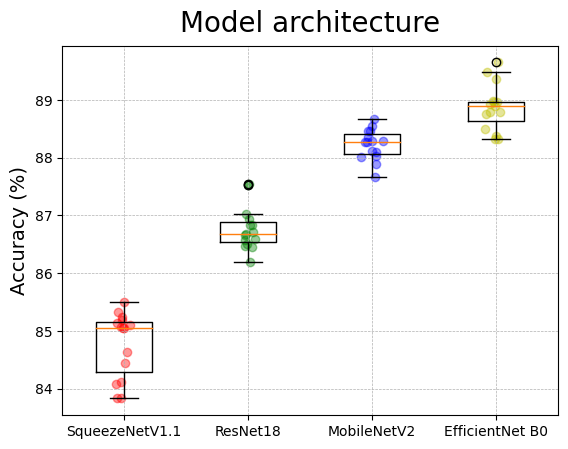

In [56]:
plot('Model architecture', ['squeezenetv11_squares',
      'resnet18_squares',
      'mobilenetv2_squares',
      'efficientnetb0_squares'],
     ['SqueezeNetV1.1',
      'ResNet18',
      'MobileNetV2',
      'EfficientNet B0'], 'different_architectures.svg')

# Influence preprocessing

## Masking vs pixel remapping

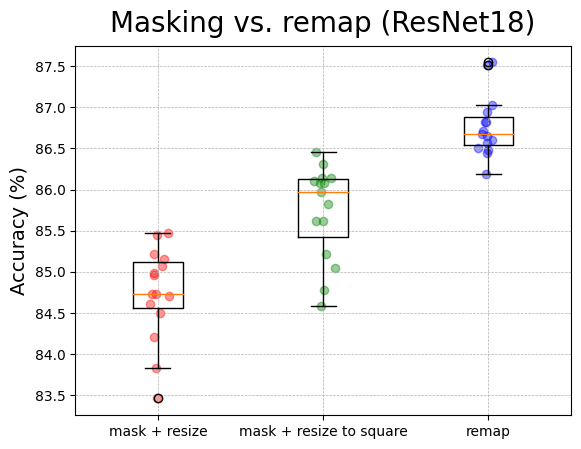

In [62]:
plot('Masking vs. remap (ResNet18)', ['resnet18_trapezoids',
      'resnet18_trapezoids_224x224',
      'resnet18_squares'],
     ['mask + resize',
      'mask + resize to square',
      'remap'], 'masking_vs_remap.svg')

## Crop remap interpolation

Procedure:

* Crop rectangle in frame
* Remap pixels in trapezoid to square

Check influence of interpolation type during remap on the accuracy

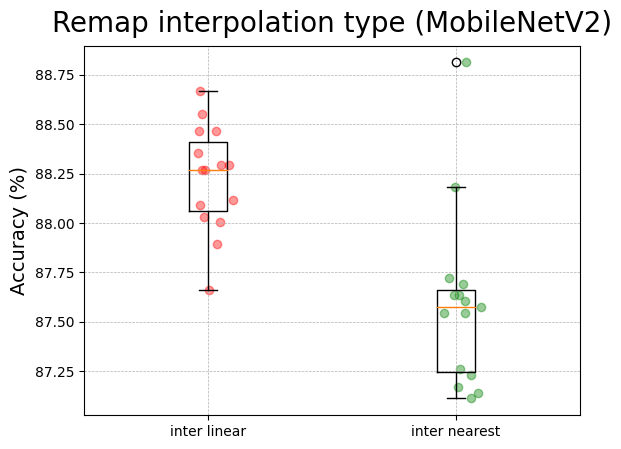

In [63]:
plot('Remap interpolation type (MobileNetV2)', ['mobilenetv2_squares',
      'mobilenetv2_inter_nearest'],
     ['inter linear',
      'inter nearest'], 'inter_linear_vs_inter_nearest.svg')

# Influence input resolution

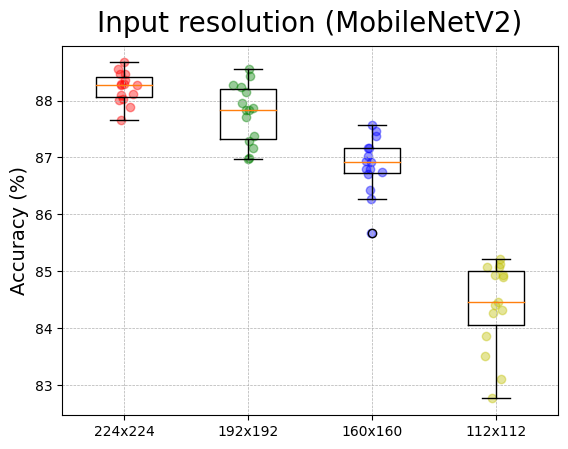

In [64]:
plot('Input resolution (MobileNetV2)', ['mobilenetv2_squares',
      'mobilenetv2_192x192',
      'mobilenetv2_160x160',
      'mobilenetv2_112x112'],
     ['224x224',
      '192x192',
      '160x160',
      '112x112'], 'input_resolution.svg')

# Quantization accuracy

Accuracies of MobileNetV2 224x224 on RockPi 3A:

| Method             | Accuracy  | Remarks                      |
|--------------------|-----------|------------------------------|
| Baseline (FP32)    | 88.24     | Accuracy in PyTorch          |
| RKNN FP16          | 88.23     |                              |
| RKNN INT8 (normal) | 87.89     | Fast PTQ algorithm           |
| RKNN INT8 (MMSE)   | **88.32** | Slow PTQ algorithm           |